This notebook explores how collaborative relationships form between mailing list participants over time.

The hypothesis, loosely put, is that early exchanges are indicators of growing relationships or trust that should be reflected in information flow at later times.

In [1]:
%matplotlib inline

Next we'll import dependencies.

In [2]:
from bigbang.archive import Archive
import bigbang.parse as parse
import bigbang.graph as graph
import bigbang.mailman as mailman
import bigbang.process as process
import bigbang.twopeople as twoppl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pprint import pprint as pp
import pytz
import math

Let's begin with just one mailing list to simplify.

In [3]:
url = "http://mail.python.org/piperpmail/scipy-dev/"
arx= Archive(url,archive_dir="../../archives")

In [4]:
arx.data.iloc[0].Body

'The link:\n\nhttp://scipy.net/mailman/listinfo/scipy-dev\n\nyou may email to scipy-dev at scipy.net to post to the list.'

In [5]:
arx.data.shape

(22489, 6)

Let's look at the matrix of who replies to whom over the whole history of the list, to get a sense of the overall distribution

In [6]:
arx.data[arx.data['In-Reply-To'] > 0][:10]

,From,Subject,Date,In-Reply-To,References,Body
Message-ID,,,,,,
<Pine.LNX.4.33.0107231957590.15960-100000@oliphant.ee.byu.edu>,oliphant at ee.byu.edu (Travis Oliphant),[SciPy-dev] RPMs and source distribution,2001-07-24 02:01:00+00:00,<02f001c111bf$2e78a9d0$777ba8c0@190xb01>,None,I've been playing for hours and finally have i...
<87snfmn8o1.fsf@jeeves.blindglobe.net>,rossini at blindglobe.net (A.J. Rossini),[SciPy-dev] RPMs and source distribution,2001-07-24 06:27:42+00:00,<Pine.LNX.4.33.0107231957590.15960-100000@olip...,<Pine.LNX.4.33.0107231957590.15960-100000@olip...,">>>>> ""TO"" == Travis Oliphant <oliphant at ee...."
<Pine.LNX.4.33.0107240041500.16169-100000@oliphant.ee.byu.edu>,oliphant at ee.byu.edu (Travis Oliphant),[SciPy-dev] RPMs and source distribution,2001-07-24 06:46:36+00:00,<87snfmn8o1.fsf@jeeves.blindglobe.net>,None,"> >>>>> ""TO"" == Travis Oliphant <oliphant at e..."
<87itgisti1.fsf@jeeves.blindglobe.net>,rossini at blindglobe.net (A.J. Rossini),[SciPy-dev] RPMs and source distribution,2001-07-24 06:58:46+00:00,<Pine.LNX.4.33.0107240041500.16169-100000@olip...,<Pine.LNX.4.33.0107240041500.16169-100000@olip...,">>>>> ""TO"" == Travis Oliphant <oliphant at ee...."
<Pine.LNX.4.33.0108021551360.838-100000@sugar.ee.byu.edu>,oliphant at ee.byu.edu (Travis Oliphant),[SciPy-dev] Spline module,2001-08-02 21:55:24+00:00,<200108021700.f72H03D17694@scipy.org>,None,>\n> Getting the new version of SciPy from CVS...
<200108031856.OAA29753@mud.cgl.uwaterloo.ca>,tjlahey at mud.cgl.uwaterloo.ca (Tim Lahey),[SciPy-dev] Re: Splines module,2001-08-03 18:56:28+00:00,"<200108031700.f73H01D31118@scipy.org> from ""sc...",None,"> \n> Date: Thu, 2 Aug 2001 15:55:24 -0600 (MD..."
<87u1z1j90m.fsf@phantom.ecn.uiowa.edu>,jmr at engineering.uiowa.edu (Joe Reinhardt),[SciPy-dev] RPMs and source distribution,2001-08-21 23:19:53+00:00,<87snfmn8o1.fsf@jeeves.blindglobe.net>\n (ross...,<Pine.LNX.4.33.0107231957590.15960-100000@olip...,Did this debian package ever materialize? \n...
<NEBBIECAMLMAAKHEGPCGCEKICMAA.travis@enthought.com>,travis at scipy.org (Travis N. Vaught),[SciPy-dev] RPMs and source distribution,2001-08-22 03:44:22+00:00,<87u1z1j90m.fsf@phantom.ecn.uiowa.edu>,None,We haven't heard anything yet about a working ...
<87u1z01ef6.fsf@jeeves.blindglobe.net>,rossini at blindglobe.net (A.J. Rossini),[SciPy-dev] RPMs and source distribution,2001-08-22 12:12:45+00:00,<NEBBIECAMLMAAKHEGPCGCEKICMAA.travis@enthought...,<NEBBIECAMLMAAKHEGPCGCEKICMAA.travis@enthought...,">>>>> ""TNV"" == Travis N Vaught <travis at scip..."


In particular we are interested in who replied to who at each time. Recall that this is an open mailing list--everybody potentially reads each message. A response from A to B is an indication that A read B's original message. Therefore, a response indicates not just a single message from A to B, but an *exchange* from B to A and back again.

Below we modify our data to see who replied to whom.

In [7]:
messages = arx.data[['From']]

responses = arx.data[arx.data['In-Reply-To'] > 0][['From','Date','In-Reply-To']]

exchanges = pd.merge(messages,responses,how='inner',right_on='In-Reply-To',left_index=True,suffixes=['_original','_response'])

exchanges

,From_original,From_response,Date,In-Reply-To
Message-ID,,,,
<87snfmn8o1.fsf@jeeves.blindglobe.net>,oliphant at ee.byu.edu (Travis Oliphant),rossini at blindglobe.net (A.J. Rossini),2001-07-24 06:27:42+00:00,<Pine.LNX.4.33.0107231957590.15960-100000@olip...
<Pine.LNX.4.33.0107240041500.16169-100000@oliphant.ee.byu.edu>,rossini at blindglobe.net (A.J. Rossini),oliphant at ee.byu.edu (Travis Oliphant),2001-07-24 06:46:36+00:00,<87snfmn8o1.fsf@jeeves.blindglobe.net>
<87itgisti1.fsf@jeeves.blindglobe.net>,oliphant at ee.byu.edu (Travis Oliphant),rossini at blindglobe.net (A.J. Rossini),2001-07-24 06:58:46+00:00,<Pine.LNX.4.33.0107240041500.16169-100000@olip...
<NEBBIECAMLMAAKHEGPCGCEKICMAA.travis@enthought.com>,jmr at engineering.uiowa.edu (Joe Reinhardt),travis at scipy.org (Travis N. Vaught),2001-08-22 03:44:22+00:00,<87u1z1j90m.fsf@phantom.ecn.uiowa.edu>
<87u1z01ef6.fsf@jeeves.blindglobe.net>,travis at scipy.org (Travis N. Vaught),rossini at blindglobe.net (A.J. Rossini),2001-08-22 12:12:45+00:00,<NEBBIECAMLMAAKHEGPCGCEKICMAA.travis@enthought...
<20010927164848.Q1356@dothill.com>,jochen at unc.edu (Jochen =?iso-8859-1?q?K=FCp...,jason at tishler.net (Jason Tishler),2001-09-27 20:48:48+00:00,<86d74cr9q2.fsf@bock.chem.unc.edu>
<86g097pgqt.fsf@bock.chem.unc.edu>,jochen at unc.edu (Jochen =?iso-8859-1?q?K=FCp...,jochen at jochen-kuepper.de (Jochen =?iso-8859...,2001-09-28 14:48:13+00:00,<86d74cr9q2.fsf@bock.chem.unc.edu>
<Pine.LNX.4.21.0109271959570.22161-100000@cens.ioc.ee>,oliphant at ee.byu.edu (Travis Oliphant),pearu at cens.ioc.ee (Pearu Peterson),2001-09-27 18:10:57+00:00,<Pine.LNX.4.33.0109271117580.25675-100000@olip...
<Pine.LNX.4.21.0109272015040.22161-100000@cens.ioc.ee>,pearu at cens.ioc.ee (Pearu Peterson),pearu at cens.ioc.ee (Pearu Peterson),2001-09-27 18:16:32+00:00,<Pine.LNX.4.21.0109271959570.22161-100000@cens...


In [8]:
exchanges.groupby(['From_original','From_response']).count()

Date  \
From_original                                      From_response                                              
00ai99 at gmail.com (David Gowers (kampu))         gael.varoquaux at normalesup.org (Gael Varoquaux)      1   
14366037 at sun.ac.za (Gouws, Almero <14366037@... ed at lamedomain.net (Ed Rahn)                         1   
                                                   matthieu.brucher at gmail.com (Matthieu Brucher)       1   
14772361 at sun.ac.za (Hamman, RA, Mr <14772361... d.l.goldsmith at gmail.com (David Goldsmith)           1   
                                                   josh.holbrook at gmail.com (Joshua Holbrook)           1   
446368 at students.wits.ac.za (Timothy Mehay)      ndbecker2 at gmail.com (Neal Becker)                   1   
Adam.Raczkowski at tufts.edu (AJ Raczkowski)       stefan at sun.ac.za (=?ISO-8859-1?Q?St=E9fan_va...     1   
Alex.Perry at ge.com (Perry, Alexander (GE Infr... oliphant at ee.byu.edu (Travis Oliphant)               1   
                                                   rkern at ucsd.edu (Robert Kern)                        2   
Andreas.Floeter at web.de (Andreas =?iso-8859-1... kamrik at gmail.com (Mark Koudritsky)                  1   
Balazs.Nemeth at shaw.ca (Balazs Nemeth)           cookedm at physics.mcmaster.ca (David M. Cooke)        1   
Bernhard.Hoefle at uibk.ac.at (Bernhard Reimar ... robert.kern at gmail.com (Robert Kern)                 1   
Brian.Newsom at Colorado.EDU (Brian Lee Newsom)    charlesnwoods at gmail.com (Gmail)                     1   
                                                   charlesnwoods at gmail.com (Nathan Woods)              2   
                                                   pav at iki.fi (Pauli Virtanen)                         2   
Chris.Barker at noaa.gov (Chris Barker)            fperez at colorado.edu (Fernando Perez)                1   
Chris.Fonnesbeck at MyFWC.com (Fonnesbeck, Chris)  perry at stsci.edu (Perry Greenfield)                  1   
Chuck.Harris at sdl.usu.edu (Chuck Harris)         clee at spiralis.merseine.nu (clee at spiralis....     1   
                                                   falted at openlc.org (Francesc Alted)                  1   
                                                   jochen at jochen-kuepper.de (Jochen =?iso-8859-...     1   
                                                   jochen at unc.edu (Jochen =?iso-8859-1?q?K=FCpp...     1   
                                                   oliphant at ee.byu.edu (Travis Oliphant)               7   
                                                   oliphant.travis at ieee.org (Travis Oliphant)          3   
                                                   pearu at cens.ioc.ee (Pearu Peterson)                  5   
                                                   pearu at scipy.org (Pearu Peterson)                    2   
                                                   pearu at scipy.org (pearu at scipy.org)                8   
D.J.Baker at soton.ac.uk (Baker D.J.)              scipy at samueljohn.de (Samuel John)                   1   
DavidA at ActiveState.com (David Ascher)           joe at enthought.com (Joe Cooper)                      1   
                                                   pearu at cens.ioc.ee (Pearu Peterson)                  1   
                                                   perry at stsci.edu (Perry Greenfield)                  1   
...                                                                                                     ...   
zachary.pincus at yale.edu (Zachary Pincus)        dwf at cs.toronto.edu (David Warde-Farley)             1   
                                                   josef.pktd at gmail.com (josef.pktd at gmail.com)      2   
                                                   jtravs at gmail.com (John Travers)                     1   
                                                   mellerf at netvision.net.il (Yosef Meller)             1

The next step is to create a DataFrame that for each pair A and B:
* The duration of time between the first reply between that pair and the last.
* The total number of replies from A to B, $r_{AB}$, and from B to A, $r_{BA}$.
* The reciprocity of the conversation $min(r_{AB},r_{BA})/max(r_{AB},r_{BA})$

Using the exchanges data frame we can use the functions in twopeople.py to calculate the above quantities. The cell below gives a sample output for calculating duration, number of replies, and reciprocity for two specific contributers.   

In [9]:
twoppl.duration(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )
twoppl.panda_pair(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )

,A,B,duration,num_replies,reciprocity
0,oliphant at ee.byu.edu (Travis Oliphant),rossini at blindglobe.net (A.J. Rossini),465 days 14:33:48,4,0.333333


The "duration" column gives us a datetime data structure so we must be careful later on when extracting information from this column. 

In [10]:
twoppl.duration(exchanges, "oliphant at ee.byu.edu (Travis Oliphant)", "rossini at blindglobe.net (A.J. Rossini)"  )

Timedelta('465 days 14:33:48')

Now let's create a dataframe that consists of these three quantities (duration, number of replies, and reciprocity) for each pair of contributers who interacted. 

To get all the unique pairs we can use the unique_pairs function in twopeople.py. This willl give us all pairs between any two individuals who had some degree of interation.

Note: The unique pairs we get back do not include reversed pairs. For example, if one of the pairs was ("Bob", "Mary"), we would not have ("Mary", "Bob") in our output.

In [11]:
pairs = twoppl.unique_pairs(exchanges)
pairs

{('nouiz at nouiz.org (=?ISO-8859-1?Q?Fr=E9d=E9ric_Bastien?=)',
  'awebster at falsecolour.com (Aaron Webster)'),
 ('ralf.gommers at googlemail.com (Ralf Gommers)',
  'lists at hilboll.de (Andreas Hilboll)'),
 ('pinto at mit.edu (Nicolas Pinto)',
  'stefan at sun.ac.za (=?ISO-8859-1?Q?St=E9fan_van_der_Walt?=)'),
 ('bsouthey at gmail.com (Bruce Southey)', 'openopt at ukr.net (dmitrey)'),
 ('cournape at gmail.com (David Cournapeau)',
  'jameskyle at ucla.edu (James Kyle)'),
 ('nwagner at iam.uni-stuttgart.de (Nils Wagner)',
  'oliphant at enthought.com (Travis Oliphant)'),
 ('millman at berkeley.edu (Jarrod Millman)',
  'brian.lee.hawthorne at gmail.com (Brian Hawthorne)'),
 ('dagss at student.matnat.uio.no (Dag Sverre Seljebotn)',
  'tmp50 at ukr.net (Dmitrey)'),
 ('mtroemel81 at web.de (=?iso-8859-15?Q?Maik_Tr=F6mel?=)',
  'robert.kern at gmail.com (Robert Kern)'),
 ('alan.mcintyre at gmail.com (Alan McIntyre)',
  'stefan at sun.ac.za (=?ISO-8859-1?Q?St=E9fan_van_der_Walt?=)'),
 ('elli

Using panda_allpairs, we can create the desired data frame

In [12]:
allpairs = twoppl.panda_allpairs(exchanges, pairs)
allpairs

,A,B,duration,num_replies,reciprocity
0,nouiz at nouiz.org (=?ISO-8859-1?Q?Fr=E9d=E9ri...,awebster at falsecolour.com (Aaron Webster),0 days 08:30:43,2,1.000000
1,ralf.gommers at googlemail.com (Ralf Gommers),lists at hilboll.de (Andreas Hilboll),50 days 16:43:27,3,0.500000
2,pinto at mit.edu (Nicolas Pinto),stefan at sun.ac.za (=?ISO-8859-1?Q?St=E9fan_v...,0 days 00:00:00,1,0.000000
3,bsouthey at gmail.com (Bruce Southey),openopt at ukr.net (dmitrey),0 days 04:21:20,3,0.500000
4,cournape at gmail.com (David Cournapeau),jameskyle at ucla.edu (James Kyle),0 days 00:00:00,1,0.000000
5,nwagner at iam.uni-stuttgart.de (Nils Wagner),oliphant at enthought.com (Travis Oliphant),0 days 00:00:00,1,0.000000
6,millman at berkeley.edu (Jarrod Millman),brian.lee.hawthorne at gmail.com (Brian Hawtho...,149 days 19:15:51,4,0.333333
7,dagss at student.matnat.uio.no (Dag Sverre Sel...,tmp50 at ukr.net (Dmitrey),0 days 10:09:14,2,1.000000
8,mtroemel81 at web.de (=?iso-8859-15?Q?Maik_Tr=...,robert.kern at gmail.com (Robert Kern),0 days 00:00:00,1,0.000000
9,alan.mcintyre at gmail.com (Alan McIntyre),stefan at sun.ac.za (=?ISO-8859-1?Q?St=E9fan_v...,0 days 00:00:00,1,0.000000


The printed values below display the counts associated for a given number of replies.

We can see  that many of the interactions have a relatively small amount of replies. One possible explanation for this large amount may be having many interactions that are merely a follow-up or question followed by a thank you response (we can explore this further by parsing the message bodies in arx.data but for now we will just speculate). 

In [13]:
print "corresponding counts for number of replies up to 19"
print ("number of replies", "frequency of occurence")
for i in range(20):
    print (i, len(allpairs[allpairs['num_replies'] <= i]) - len(allpairs[allpairs['num_replies'] <= i - 1]))

corresponding counts for number of replies up to 19
('number of replies', 'frequency of occurence')
(0, 0)
(1, 2142)
(2, 932)
(3, 361)
(4, 264)
(5, 129)
(6, 111)
(7, 76)
(8, 63)
(9, 44)
(10, 47)
(11, 24)
(12, 27)
(13, 13)
(14, 20)
(15, 15)
(16, 23)
(17, 7)
(18, 12)
(19, 10)


Text(0.5,1,u'Number of replies')

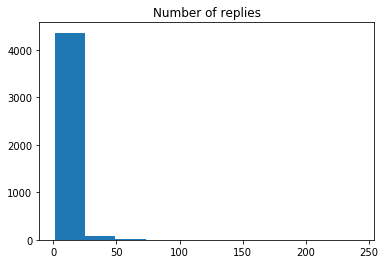

In [14]:
plt.hist(allpairs['num_replies'])
plt.title("Number of replies")

To get a better idea of what's going on for larger values, let's look at the rows that have number of replies greater than 5. 

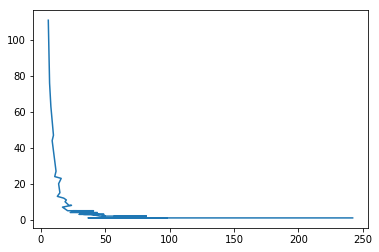

In [15]:
greaterThanFive = allpairs[allpairs['num_replies'] > 5]['num_replies']
counts = greaterThanFive.value_counts()
counts.plot()

The graph seems to follow a power law which is expected for this type of data. 

Now let's see if we can find any patters between the number of replies and reciprocity. Intuitively, we would expect that the number of replies be positively associated with reciprocity but let's see... 

We will first look at the data for which the number of replies is greater than 5 to possibly get rid of some noise (later on we will explore the data without removing these entries). 

Below we divided reciprocity and number of replies into completely arbitrary bins as shown below. Hopefully, this will make it easier to see patters between these two variables as they have quite a bit of noise. 

(The genId and genNumReplies functions just give each entry a corresponding label for graphing purposes later on. These labels are based on which bin a given entry falls under) 

In [16]:
#Completely arbitrary bins

#Group A reciprocity between (0, .25]
#Group B reciprocity between (.25, .5] 
#Group C reciprocity between (.5, .75]  
#Group D reciprocity between (.75, 1.00]

#"low" number of replies less than or equal to 10
#"moderate" number of replies between 10 and 20
#"high" replies greater than 20 replies 

def genId(num):
    if num <= .25:
        return 'A.(0, .25]'
    if num <= .5:
        return "B.(.25, .5]"
    if num <= .75:
        return "C.(.5, .75]"
    return "D.(.75, 1.00]"

def genNumReplies(num):
    if num <= 10:
        return 'a.low'
    if num <= 20:
        return "b.moderate"
    return "c.high"

The following lines generate a data frame that contains three columns:
1) Number of replies
2) Id corresponding to replies bin
3) Id corresponding to reciprocity bin

(The extra letters such as the a in "a.low" are just used so that pandas orders the columns in the way we want)

In [17]:
moreThanFive = allpairs[allpairs['num_replies'] > 5]
recipVec = moreThanFive['reciprocity']
numReplies = moreThanFive['num_replies']
ids = recipVec.apply(lambda val: genId(val))
groupedRep = numReplies.apply(lambda val: genNumReplies(val))
groupsdf = pd.DataFrame({"num_replies": numReplies, "ids": ids, "grouped_num_replies": groupedRep})
groupsdf


,grouped_num_replies,ids,num_replies
11,b.moderate,"A.(0, .25]",18
33,a.low,"D.(.75, 1.00]",6
47,a.low,"B.(.25, .5]",9
48,b.moderate,"D.(.75, 1.00]",13
50,a.low,"D.(.75, 1.00]",6
55,c.high,"D.(.75, 1.00]",55
59,a.low,"C.(.5, .75]",8
66,c.high,"D.(.75, 1.00]",58
85,b.moderate,"D.(.75, 1.00]",19
91,c.high,"D.(.75, 1.00]",41


Now that we have this data frame lets look at the corresponding histograms for each "level" of reciprocity.

Text(0.5,1,u'Number of Replies for Reciprocity between 0-.25')

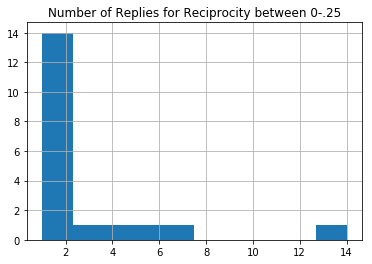

In [18]:

grpA = groupsdf[groupsdf["ids"] == "A.(0, .25]"]['num_replies']
grpB = groupsdf[groupsdf["ids"] == "B.(.25, .5]"]['num_replies']
grpC = groupsdf[groupsdf["ids"] == "C.(.5, .75]"]['num_replies']
grpD = groupsdf[groupsdf["ids"] == "D.(.75, 1.00]"]['num_replies']
grpA.value_counts().hist()
plt.title("Number of Replies for Reciprocity between 0-.25")

Text(0.5,1,u'Number of Replies for Reciprocity between .25-.5')

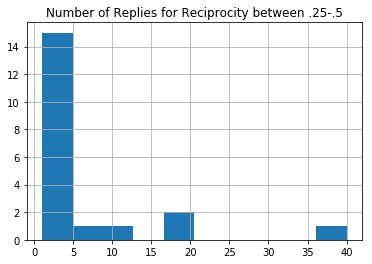

In [19]:
grpB.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .25-.5")

Text(0.5,1,u'Number of Replies for Reciprocity between .5-.75')

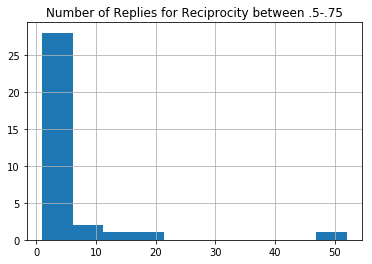

In [20]:
grpC.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .5-.75")

Text(0.5,1,u'Number of Replies for Reciprocity between .75-1.0')

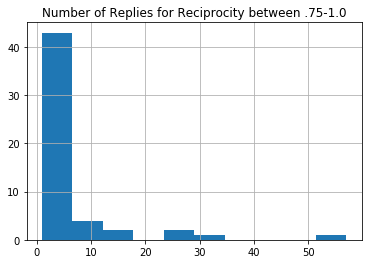

In [21]:
grpD.value_counts().hist()
plt.title("Number of Replies for Reciprocity between .75-1.0")

It's pretty hard to compare the four histograms so let's create a contingency table for the groupsdf data frame. 

In [22]:
crossed = pd.crosstab(groupsdf["grouped_num_replies"], groupsdf["ids"])
crossed

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,29,86,83,143
b.moderate,13,16,50,83
c.high,7,8,29,79


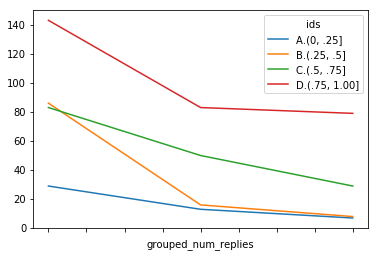

In [23]:
crossed.plot()

Since each reciprocity group has a different amount of counts, let's normalize the counts to get a better picture of what's going on. 

We will first normzalize column-wise, that is for say column A.[0,.25] we will sum the total number of responses and get the relative proportions for the replies bins. 

In [24]:
crossed.apply(lambda r: r/sum(r), axis=0)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.591837,0.781818,0.512346,0.468852
b.moderate,0.265306,0.145455,0.308642,0.272131
c.high,0.142857,0.072727,0.179012,0.259016


We see that at the very extremes, namely reciprocity between 0-.25 and reciprocity between .75-1.0, there are some clear differences; reciprocity seems to be positively associated with the number of replies as we had initially expected.

On the other hand, the bin for reciprocity between .25-.5 weakens this association as this bin seems as if it should swap positions with bin A. However, since the bin widths we chose were completely arbitrary it may explain this paradox. 

The fact that the extremes seem to follow our expectations is quite interesting; it provides some evidence that if we choose our bin sizes appropriately, we can perhaps get a nice positive association. 

Text(0.5,1,u'normalized (columnwise) plot')

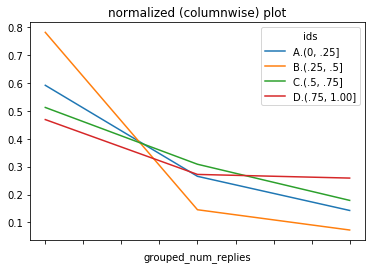

In [25]:
crossed.apply(lambda r: r/sum(r), axis=0).plot()
plt.title("normalized (columnwise) plot")

Now will do the normalization by row. This will give us the relative proportion of some bin for number of replies is distributed across the bins for reciprocity.

In [26]:
crossed.apply(lambda r: r/sum(r), axis=1)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.085044,0.252199,0.243402,0.419355
b.moderate,0.080247,0.098765,0.308642,0.512346
c.high,0.056911,0.065041,0.235772,0.642276


Text(0.5,1,u'normalized (row-wise) plot')

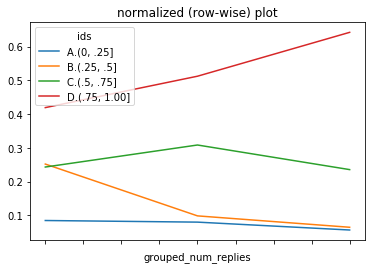

In [27]:
crossed.apply(lambda r: r/sum(r), axis=1).plot()
plt.title("normalized (row-wise) plot")

Now let's go back and do the exact same thing but not removing entries with a very low amount of replies. 

In [28]:
recipVec2 = allpairs['reciprocity']
numReplies2 = allpairs['num_replies']
ids = recipVec2.apply(lambda val: genId(val))
groupedRep2 = numReplies2.apply(lambda val: genNumReplies(val))
groupsdf2 = pd.DataFrame({"num_replies": numReplies2, "ids": ids, "grouped_num_replies": groupedRep2})

In [29]:
crossed2 = pd.crosstab(groupsdf2["grouped_num_replies"], groupsdf2["ids"])
crossed2

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,2535,470,176,988
b.moderate,13,16,50,83
c.high,7,8,29,79


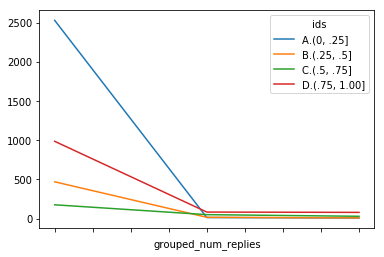

In [30]:
crossed2.plot()

In [31]:
crossed2.apply(lambda r: r/sum(r), axis=0)

ids,"A.(0, .25]","B.(.25, .5]","C.(.5, .75]","D.(.75, 1.00]"
grouped_num_replies,,,,
a.low,0.992172,0.951417,0.690196,0.859130
b.moderate,0.005088,0.032389,0.196078,0.072174
c.high,0.002740,0.016194,0.113725,0.068696


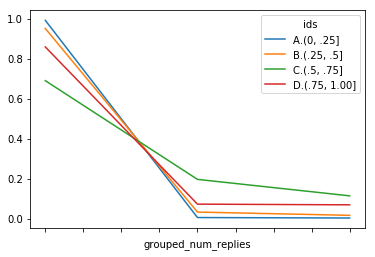

In [32]:
crossed2.apply(lambda r: r/sum(r), axis=0).plot()

Now we will look at various scatterplots for different variables to get a rough sense of how our data is spread. 

Text(0.5,1,u'number of replies vs. reciprocity')

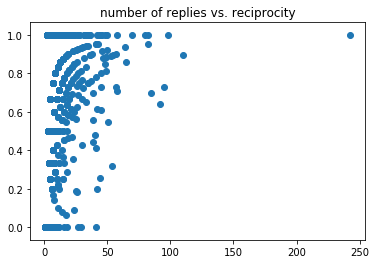

In [33]:
plt.scatter(allpairs.num_replies, allpairs.reciprocity)
plt.title("number of replies vs. reciprocity")

In [34]:
allpairs['duration']

0         0 days 08:30:43
1        50 days 16:43:27
2         0 days 00:00:00
3         0 days 04:21:20
4         0 days 00:00:00
5         0 days 00:00:00
6       149 days 19:15:51
7         0 days 10:09:14
8         0 days 00:00:00
9         0 days 00:00:00
10        0 days 00:00:00
11       37 days 00:24:16
12        0 days 00:35:01
13        0 days 00:00:00
14      100 days 19:51:57
15        0 days 00:00:00
16        0 days 00:00:00
17        0 days 00:00:00
18        0 days 01:18:25
19        0 days 00:16:02
20      574 days 14:01:37
21        0 days 00:00:00
22       13 days 17:56:10
23       14 days 23:50:07
24        0 days 00:00:00
25      726 days 10:03:39
26        8 days 04:32:28
27        0 days 00:00:00
28        0 days 06:02:02
29        3 days 16:12:27
              ...        
4424      0 days 00:00:00
4425    177 days 01:03:49
4426      0 days 00:00:00
4427      0 days 00:00:00
4428      0 days 00:00:00
4429     51 days 20:42:57
4430      0 days 23:36:05
4431      0 

Text(0.5,1,u'duration vs. number of replies')

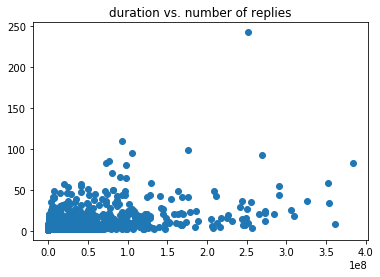

In [35]:
allpairs['duration'] = allpairs['duration'].apply(lambda x: x / np.timedelta64(1, 's'))
plt.scatter(allpairs.duration, allpairs.num_replies)
plt.title("duration vs. number of replies")

Now let's look at some scatterplots for the entries with number of replies greater than 5.

Text(0.5,1,u'reciprocity vs. duration')

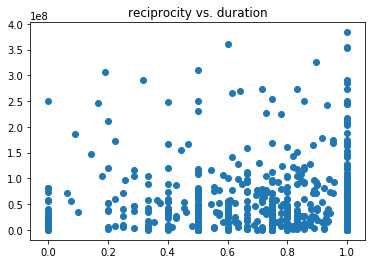

In [36]:
df_filt = allpairs[allpairs['num_replies'] > 5]
plt.scatter(df_filt.reciprocity, df_filt.duration)
plt.title("reciprocity vs. duration")

Text(0.5,1,u'reciprocity vs. log of duration')

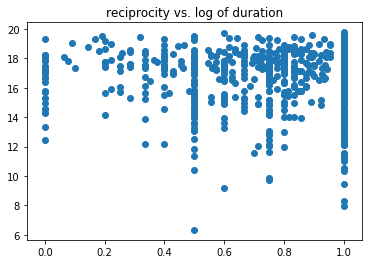

In [37]:
plt.scatter(df_filt.reciprocity, df_filt.duration.apply(lambda x: math.log(x)))
plt.title("reciprocity vs. log of duration")

Text(0.5,1,u'log of duration vs. log of number of replies')

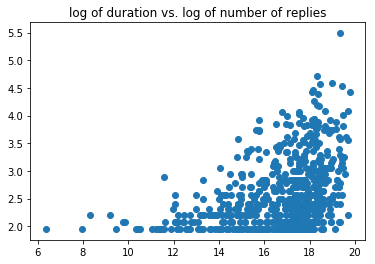

In [38]:
plt.scatter(df_filt.duration.apply(lambda x: math.log(x+1)), df_filt.num_replies.apply(lambda x: math.log(x+1)))
plt.title("log of duration vs. log of number of replies")

Since we actually have the bodies of each message, we will now procceed by seeing if there are any patterns between the type of messages sent and reciprocity, duration, and the number of replies. 

As a very rough measure, we have created a function calMessageLen that calculates the length of a given message. 

In [39]:
def calMessageLen(message):
    if message == None:
        return 0
    return len(message)

arx.data['length'] = arx.data['Body'].apply(lambda x: calMessageLen(x))
arx.data

,From,Subject,Date,In-Reply-To,References,Body,length
Message-ID,,,,,,,
<NEBBIECAMLMAAKHEGPCGKEBHCLAA.travis@vaught.net>,travis at vaught.net (Travis N. Vaught),[SciPy-dev] SciPy Developer mailing list now o...,2001-06-11 02:10:51+00:00,None,None,The link:\n\nhttp://scipy.net/mailman/listinfo...,116
<Pine.LNX.4.33.0107231957590.15960-100000@oliphant.ee.byu.edu>,oliphant at ee.byu.edu (Travis Oliphant),[SciPy-dev] RPMs and source distribution,2001-07-24 02:01:00+00:00,<02f001c111bf$2e78a9d0$777ba8c0@190xb01>,None,I've been playing for hours and finally have i...,203
<87snfmn8o1.fsf@jeeves.blindglobe.net>,rossini at blindglobe.net (A.J. Rossini),[SciPy-dev] RPMs and source distribution,2001-07-24 06:27:42+00:00,<Pine.LNX.4.33.0107231957590.15960-100000@olip...,<Pine.LNX.4.33.0107231957590.15960-100000@olip...,">>>>> ""TO"" == Travis Oliphant <oliphant at ee....",800
<Pine.LNX.4.33.0107240041500.16169-100000@oliphant.ee.byu.edu>,oliphant at ee.byu.edu (Travis Oliphant),[SciPy-dev] RPMs and source distribution,2001-07-24 06:46:36+00:00,<87snfmn8o1.fsf@jeeves.blindglobe.net>,None,"> >>>>> ""TO"" == Travis Oliphant <oliphant at e...",753
<87itgisti1.fsf@jeeves.blindglobe.net>,rossini at blindglobe.net (A.J. Rossini),[SciPy-dev] RPMs and source distribution,2001-07-24 06:58:46+00:00,<Pine.LNX.4.33.0107240041500.16169-100000@olip...,<Pine.LNX.4.33.0107240041500.16169-100000@olip...,">>>>> ""TO"" == Travis Oliphant <oliphant at ee....",700
<20010725005337.PHSJ11181.tomts14-srv.bellnexxia.net@localhost>,tjlahey at mud.cgl.uwaterloo.ca (Tim Lahey),[SciPy-dev] Building SciPy on Mac OS X,2001-07-25 00:53:00+00:00,None,None,"All,\n\nI've decide that I'm going to tackle g...",882
<20010725034411.SATM11181.tomts14-srv.bellnexxia.net@localhost>,tjlahey at mud.cgl.uwaterloo.ca (Tim Lahey),[SciPy-dev] Building SciPy on Mac OS X Part II,2001-07-25 03:43:46+00:00,None,None,"All,\n\nAs I mentioned in my previous message,...",518
<20010801231139.YWP4521.tomts13-srv.bellnexxia.net@localhost>,tjlahey at mud.cgl.uwaterloo.ca (Tim Lahey),[SciPy-dev] Splines in SciPy,2001-08-01 23:09:41+00:00,None,None,"All,\n\nGetting the new version of SciPy from ...",796
<024e01c11b4e$f5510050$7600a8c0@ericlaptop>,eric at scipy.org (eric jones),Fw: [SciPy-dev] Splines in SciPy,2001-08-02 12:30:42+00:00,None,None,"Hey Tim,\n\n I just noticed this addition too....",2031
